In [12]:
# ACCESS THE API!!!! 
# 29A091BD-3865-4E63-ADF9-3D4892DF0661

import pandas as pd
import requests

def get_api_data(url, params, headers=None):
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        data = response.json()
        df = pd.json_normalize(data)
        return df
    else:
        print(f"Error with request {url}: {response.status_code}")
        return None

api_key = '29A091BD-3865-4E63-ADF9-3D4892DF0661'
headers = {'accept': 'application/json'}
start_date = '1/1/2018'
end_date = '12/31/2018'

# Define your URLs and params outside the function calls for clarity
urls_and_params = [
    ('https://api.irwd.com/api/Daily', {'apiKey': api_key, 'startDate': start_date, 
                                        'endDate': end_date, 'includeCentral': 'true', 
                                        'includeCoastal': 'true', 'includeFoothills': 'true'}),
    ('https://api.irwd.com/api/DailyET', {'apiKey': api_key}),
    ('https://api.irwd.com/api/PotableWeekly', {'apiKey': api_key}),
    ('https://api.irwd.com/api/RecycledWeekly', {'apiKey': api_key}),
    ('https://api.irwd.com/api/Station', {'apiKey': api_key}),
]

# Loop through each URL and param set, making the request and processing the response
for url, params in urls_and_params:
    df = get_api_data(url, params, headers)
    if df is not None:
        print(f"Data from {url}:")
        print(df.head())  # Print the first few rows to verify the data
        print("\n")  # Add a newline for better readability between different datasets


# # Just grabbing daily data

# import pandas as pd
# import requests

# def get_api_data(url, params, headers=None):
#     response = requests.get(url, params=params, headers=headers)
#     if response.status_code == 200:
#         data = response.json()
#         df = pd.json_normalize(data)
#         return df
#     else:
#         print(f"Error with request {url}: {response.status_code}")
#         return None

# # Your API key and headers
# api_key = '29A091BD-3865-4E63-ADF9-3D4892DF0661'
# headers = {'accept': 'application/json'}

# # Daily Data API URL and parameters
# daily_url = 'https://api.irwd.com/api/Daily'
# daily_params = {
#     'apiKey': api_key,
#     'startDate': '1/1/2018',
#     'endDate': '12/31/2018',
#     'includeCentral': 'true',
#     'includeCoastal': 'true',
#     'includeFoothills': 'true'
# }

# daily_data_df = get_api_data(daily_url, daily_params)

# # Path to your existing CSV file
# csv_file_path = "/Users/kelseyhawkins/Library/CloudStorage/OneDrive-FormaBrands/IRWD - Piechota, Thomas's files/Kelsey/19-24_precip.csv"

# # Load the CSV file into a DataFrame
# existing_df = pd.read_csv(csv_file_path)

# if daily_data_df is not None:
#     # Append the new data to the existing DataFrame
#     updated_df = pd.concat([existing_df, daily_data_df], ignore_index=True)
# else:
#     # If there was an error fetching the daily data, use the existing DataFrame
#     updated_df = existing_df


# # Save the updated DataFrame to the same CSV file, overwriting the old content
# updated_df.to_csv(csv_file_path, index=False)








In [1]:
# Data Engineering
# ----- WARNING ------ 
# 10+ mins to run on my home wifi!
# 2 mins on CU wifi!

import warnings 
warnings.filterwarnings('ignore')
import sqlite3
import pandas as pd

conn = sqlite3.connect("/Users/kelseyhawkins/Library/CloudStorage/OneDrive-FormaBrands/IRWD - Piechota, Thomas's files/Kelsey/irwd.db")
cursor = conn.cursor()

#Grabbing 10% of the database
sample_query = "SELECT * FROM service_data ORDER BY RANDOM() LIMIT (SELECT COUNT(*) FROM service_data)/10"
sampled_df = pd.read_sql_query(sample_query, conn)

conn.commit()
conn.close()

# Grabbing Residential data only
expanded_df = sampled_df['SP_TYPE_DESCR'].str.split(" - ", expand=True)
expanded_df.columns = ['Category', 'Type', 'Service', 'extra1', 'extra2']
sampled_df = pd.concat([sampled_df, expanded_df], axis=1)

residential_df = sampled_df[sampled_df['Category'].str.contains('RESIDENTIAL', na=False, case=False)].copy()
residential_df['SA_START_DT'] = pd.to_datetime(residential_df['SA_START_DT'], format='%Y%m%d')
residential_df['BILL_AMT'] = residential_df['BILL_AMT'].fillna(0)
residential_df[['Category', 'Type', 'Service', 'extra1', 'extra2']] = residential_df[['Category', 'Type', 'Service', 'extra1', 'extra2']].fillna(0)

# Combining ET data and billing data
ET_Data = pd.read_csv("/Users/kelseyhawkins/OneDrive - Chapman University/IRWD - Piechota, Thomas's Files/Kelsey/Sample Data Files/ET_Data18to23.csv")
ET_Data['EFFDT'] = pd.to_datetime(ET_Data['EFFDT'], format='%m/%d/%Y %H:%M:%S')
ET_Data.set_index(['EFFDT', 'ET_ZONE'], inplace=True)
ET_Data['VALUE'] = ET_Data['VALUE'].astype(float).fillna(0.0)
ET_Data = ET_Data.drop(columns='CHAR_TYPE_CD')
monthlyET = ET_Data.groupby(level='ET_ZONE').resample('M', level=0).sum()
if 'ET_ZONE' not in monthlyET.columns:
    monthlyET = monthlyET.reset_index()
residential_df = residential_df[residential_df['SA_START_DT'] > '2017-12-31']
monthlyET['Month_Year'] = monthlyET['EFFDT'].dt.to_period('M')
residential_df['Month_Year'] = residential_df['SA_START_DT'].dt.to_period('M')
combined_df = pd.merge(residential_df, monthlyET, left_on=['Month_Year', 'ET_ZONE'], right_on=['Month_Year', 'ET_ZONE'], how='left')
combined_df['usage_daily'] = combined_df['USAGE_CCF']/combined_df['BILL_DAYS']

# Combining climate data with ET and billing
climate = pd.read_csv("/Users/kelseyhawkins/Library/CloudStorage/OneDrive-FormaBrands/IRWD - Piechota, Thomas's files/Kelsey/19-24_precip.csv")
climate['date'] = pd.to_datetime(climate['date'], errors='coerce', infer_datetime_format=True)
climate = climate.dropna(axis=1, how='all')
climate['ET_ZONE'] = climate['stationName'].apply(lambda x: 1 if "coastal" in x.lower() else (2 if "central" in x.lower() else 3))
climate.set_index(['date', 'ET_ZONE', 'stationName'], inplace= True)
monthlyClimate = climate.groupby(level = 'ET_ZONE').resample('M', level=0).sum()
if 'ET_ZONE' not in monthlyClimate.columns:
    monthlyClimate = monthlyClimate.reset_index()
monthlyClimate['Month_Year'] = monthlyClimate['date'].dt.to_period('M')
monthlyClimate.drop(columns='etoFlag', inplace=True)
finalDF = pd.merge(combined_df, monthlyClimate, left_on = ['Month_Year', 'ET_ZONE'], right_on = ['Month_Year', 'ET_ZONE'], how = 'left')
finalDF['year'] = finalDF['Month_Year'].dt.year

# Last changes with data types ...
cols = ['DW_UNITS', 'ET_ZONE', 'LANDS_AC', 'LANDS_SF', 'BILL_AMT', 'CHARGE_LOW', 'CHARGE_BASE', 
        'CHARGE_INEFFICIENT', 'CHARGE_WASTEFUL', 'WATER_SERVICE_CHARGE', 'SEWER_SERVICECHARGE',
        'ADJ_BILL']
finalDF[cols] = finalDF[cols].replace('NULL', pd.NA).fillna(0)
finalDF[cols] = finalDF[cols].astype('int64')
finalDF.drop(finalDF['BILL_AMT'].idxmax(), inplace= True)
# Assuming df is your DataFrame and 'Type' is your column
top_6_categories = finalDF['Type'].value_counts().nlargest(4).index
finalDF = finalDF[finalDF['Type'].isin(top_6_categories)]

# Wet month calculations
monthly_yr_precip = pd.DataFrame(finalDF.groupby('Month_Year')['precip'].mean())
threshold = monthly_yr_precip['precip'].quantile(0.75)
finalDF['wet_month'] = (finalDF['precip'] > threshold).astype(int)

# ------ END OF DATA ENGINEERING --------- #

In [7]:
finalDF['Type'].value_counts()
finalDF.groupby('Type')['usage_daily'].mean()

# Type
# APARTMENT         0.127733
# CONDO             0.161682
# DETACHED CONDO    0.191243
# SINGLE FAMILY     0.354206

Type
APARTMENT         0.128227
CONDO             0.162420
DETACHED CONDO    0.188470
SINGLE FAMILY     0.350979
Name: usage_daily, dtype: float64

In [8]:
print(finalDF['Type'].value_counts())
# Type
# SINGLE FAMILY     105155
# CONDO              76235
# APARTMENT          23135
# DETACHED CONDO     17027
print(finalDF['Category'].value_counts())
# Category
# RESIDENTIAL    221552
finalDF['Service'].value_counts()
# Service
# POTABLE WATER & SEWER    216220
# POTABLE WATER              5332

finalDF[['CITY', 'ET_ZONE']].value_counts()
# CITY            ET_ZONE
# IRVINE          2          142163
# LAKE FOREST     2           21802
# IRVINE          3           15688
# TUSTIN          2           12809
# NEWPORT BEACH   1            8554
# TUSTIN          3            5153
# FOOTHILL RANCH  3            4845
# LAKE FOREST     3            3482
# COSTA MESA      1            3183
# TRABUCO CANYON  3            2538
# SILVERADO       3             865
# ORANGE          3             117
# NEWPORT COAST   1              25
# NEWPORT BEACH   2              11
# SILVERADO       2               1

Type
SINGLE FAMILY     104767
CONDO              76430
APARTMENT          23272
DETACHED CONDO     16872
Name: count, dtype: int64
Category
RESIDENTIAL    221341
Name: count, dtype: int64


CITY            ET_ZONE
IRVINE          2          141728
LAKE FOREST     2           21747
IRVINE          3           15928
TUSTIN          2           12879
NEWPORT BEACH   1            8492
TUSTIN          3            5189
FOOTHILL RANCH  3            5069
LAKE FOREST     3            3522
COSTA MESA      1            3192
TRABUCO CANYON  3            2533
SILVERADO       3             904
ORANGE          3             123
NEWPORT COAST   1              26
NEWPORT BEACH   2               9
Name: count, dtype: int64

In [4]:
finalDF.columns

Index(['ACCT_ID', 'SP_ID', 'PER_ID', 'SA_ID', 'SA_START_DT', 'SA_END_DT',
       'SA_STATUS', 'SP_TYPE', 'SP_TYPE_DESCR', 'CUST_NAME', 'ADDRESS', 'CITY',
       'STATE', 'POSTAL', 'DEFAULT_RES', 'DEFAULT_RES_EFFDT', 'VARADPER',
       'VARADPER_EFFDT', 'DW_UNITS', 'DW_UNITS_EFFDT', 'ET_ZONE', 'LANDS_AC',
       'LANDS_AC_EFFDT', 'LANDS_SF', 'LANDS_SF_EFFDT', 'WATER_SOURCE',
       'BSEG_ID', 'CM_BILLINF_START_DT', 'CM_BILLINF_END_DT', 'BILL_DAYS',
       'BILL_AMT', 'USAGE_CCF', 'TOTALOC', 'USAGE_LOW', 'CHARGE_LOW',
       'USAGE_BASE', 'CHARGE_BASE', 'USAGE_INEFFICIENT', 'CHARGE_INEFFICIENT',
       'USAGE_WASTEFUL', 'CHARGE_WASTEFUL', 'WATER_SERVICE_CHARGE',
       'SEWER_SERVICECHARGE', 'ADJ_BILL', 'XCOORD', 'YCOORD', 'Category',
       'Type', 'Service', 'extra1', 'extra2', 'Month_Year', 'EFFDT', 'VALUE',
       'usage_daily', 'date', 'record', 'maxAirTmp', 'timeMaxAirTmp',
       'minAirTmp', 'timeMinAirTmp', 'avgAirTmp', 'avgRelHum', 'avgWindSpeed',
       'maxWindSpeed', 'timeMa

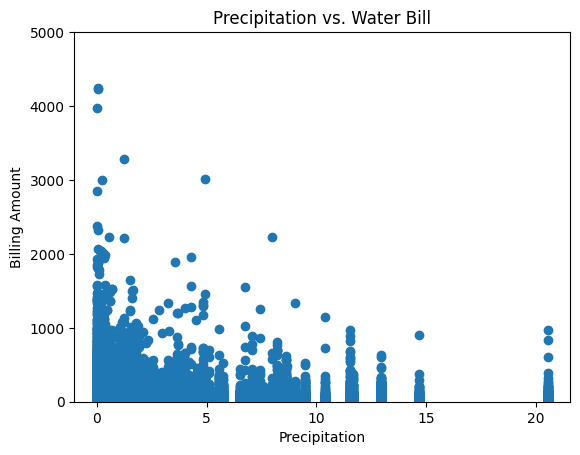

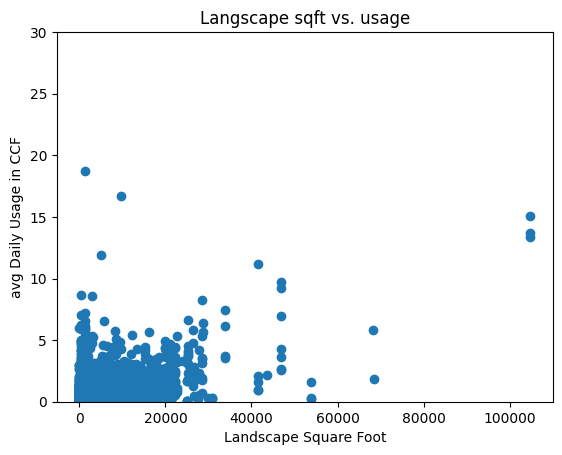

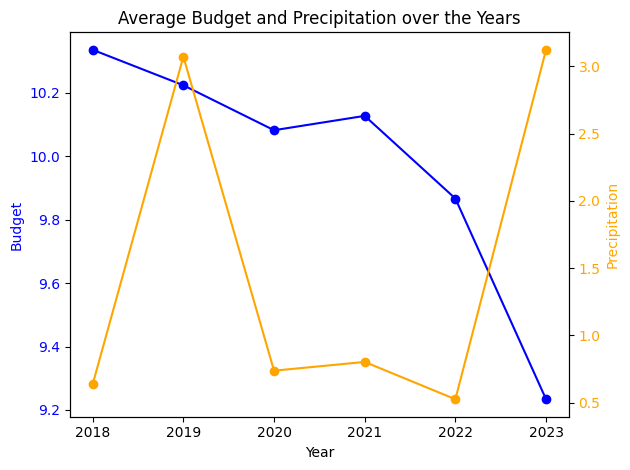

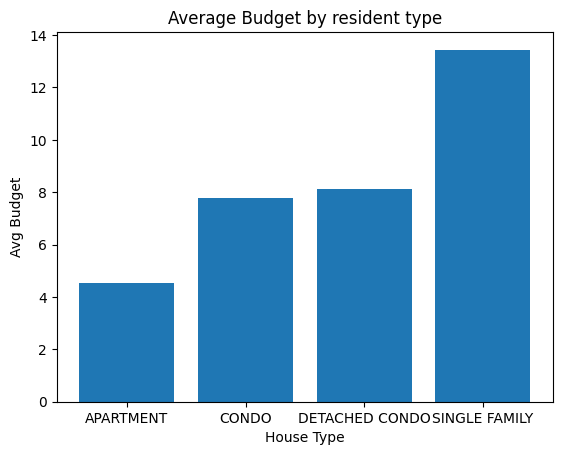

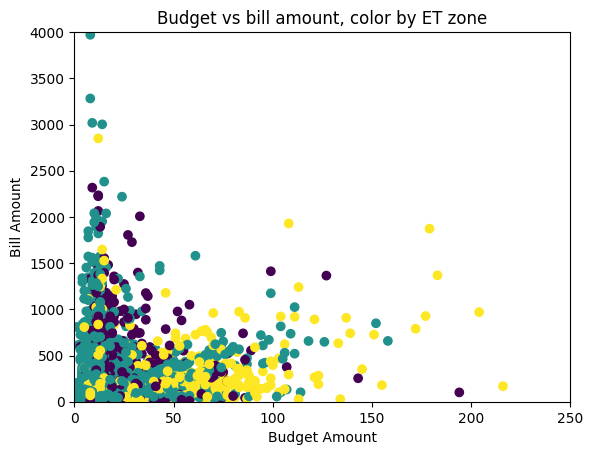

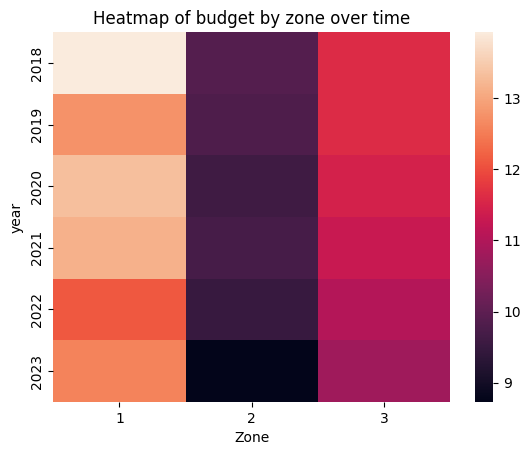

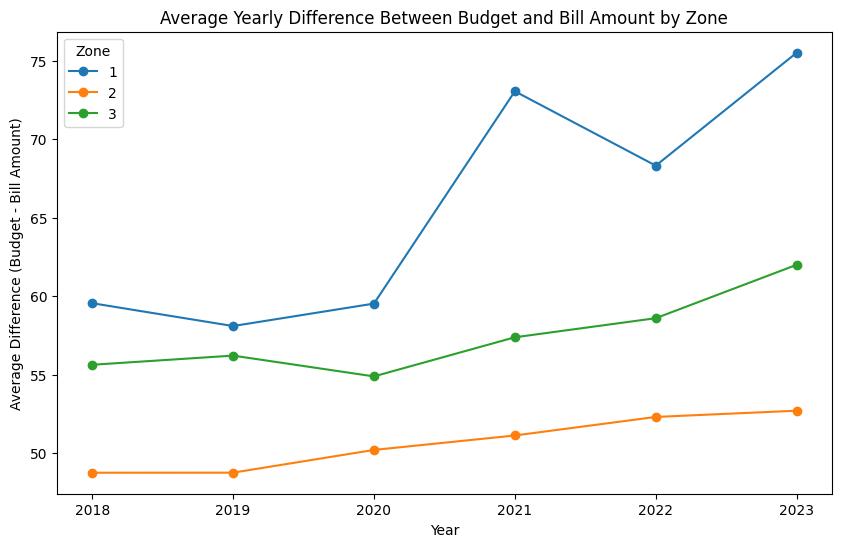

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
# A basic trend analysis over time for usage and ET data

# Precip vs water bill
plt.scatter(finalDF['precip'], finalDF['BILL_AMT'])
plt.ylim(0,5000)
plt.xlabel('Precipitation')
plt.ylabel('Billing Amount')
plt.title('Precipitation vs. Water Bill')
plt.show()

# Daily usage vs landscape sqft
plt.scatter(finalDF['LANDS_SF'], finalDF['usage_daily'])
plt.ylim(0,30)
plt.xlabel('Landscape Square Foot')
plt.ylabel('avg Daily Usage in CCF')
plt.title('Langscape sqft vs. usage')
plt.show()

# Budget and precip over the years
budget_avg = finalDF.groupby('year')['TOTALOC'].mean()
precip_avg = finalDF.groupby('year')['precip'].mean()
fig, ax1 = plt.subplots()
ax1.set_xlabel('Year')
ax1.set_ylabel('Budget', color='blue')
ax1.plot(budget_avg.index, budget_avg, color='blue', marker='o', label='Budget')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('Precipitation', color='orange')
ax2.plot(precip_avg.index, precip_avg, color='orange', marker='o', label='Precipitation')
ax2.tick_params(axis='y', labelcolor='orange')
plt.title('Average Budget and Precipitation over the Years')
fig.tight_layout()
plt.show()

# Budget by house type 
budget_avg = finalDF.groupby('Type')['TOTALOC'].mean()
plt.bar(budget_avg.index, budget_avg.values)
plt.xlabel("House Type")
plt.ylabel("Avg Budget")
plt.title("Average Budget by resident type")
plt.show()

# Budget versus usage, colored by ET ZONE
plt.scatter(finalDF['TOTALOC'], finalDF['BILL_AMT'],
             c = finalDF['ET_ZONE'], cmap = 'viridis')
plt.xlabel("Budget Amount")
plt.xlim(0,250)
plt.ylim(0,4000)
plt.ylabel("Bill Amount")
plt.title("Budget vs bill amount, color by ET zone")
plt.show()

# Budget heatmap by zone
heatmap_data = finalDF.pivot_table(index = 'year', columns = 'ET_ZONE', values = 'TOTALOC')
sns.heatmap(heatmap_data)
plt.title("Heatmap of budget by zone over time")
plt.xlabel("Zone")
plt.ylabel("year")
plt.show

# Yearly difference of budget and bill amt by zone
finalDF['Difference'] = finalDF['BILL_AMT'] - finalDF['TOTALOC'] 
yearly = finalDF.groupby(['year', 'ET_ZONE'])['Difference'].mean().reset_index()
yearly_pivot = yearly.pivot(index = 'year', columns = 'ET_ZONE', values = 'Difference')
fig, ax = plt.subplots(figsize = (10,6))
for column in yearly_pivot.columns:
    ax.plot(yearly_pivot.index, yearly_pivot[column], label = column, marker = 'o')
ax.set_xlabel('Year')
ax.set_ylabel('Average Difference (Budget - Bill Amount)')
ax.set_title('Average Yearly Difference Between Budget and Bill Amount by Zone')
ax.legend(title = 'Zone')
plt.show()



# Now that we have visualized the heck out of the data... lets do some ML!

Given the type of data you have—precipitation, wet month classification, budget for water usage, actual water usage, and amount billed in CCF units—there are several statistical tests and machine learning algorithms that can be applied to extract insights and make predictions. Here are some suggestions:

### Statistical Tests
* Correlation Analysis: To check the strength and direction of the relationship between variables, you can use Pearson's correlation for continuous variables and Spearman's rank correlation if your data is not normally distributed or if the relationship is not linear.
* Time Series Analysis: If your data is chronological, time series analysis can be very insightful. You could use ARIMA (Autoregressive Integrated Moving Average) models to forecast water usage or billing amounts based on past values.
* Regression Analysis: If you're looking to predict a continuous variable (e.g., actual water usage or amount billed), linear regression can be used. For more complex relationships, polynomial regression or non-linear models may be more appropriate.
* Variance Analysis (ANOVA): If you want to compare the means of water usage or billing amounts across different groups (e.g., wet months vs. dry months), ANOVA can be used.
## Machine Learning Algorithms
### Regression Models:
* Linear Regression: For predicting a continuous outcome such as the amount of water used.
* Ridge/Lasso Regression: If you have many correlated predictors, these can help with regularization.
* Random Forest Regressor: A non-linear approach that can capture complex relationships between features.
* Classification Models (if you have categorical outcomes like whether a budget was exceeded):
* Logistic Regression: For binary classification problems.
* Decision Trees: For non-linear decision boundaries.
* Random Forest Classifier: For better performance through ensembling.
* Support Vector Machines (SVM): Effective in high-dimensional spaces.
### Clustering:
* K-Means Clustering: If you're looking to segment customers or months into groups based on usage patterns.
* Hierarchical Clustering: For a hierarchical segmentation that doesn't require pre-specifying the number of clusters.
### Time Series Forecasting:
* ARIMA/SARIMA: For forecasting future water usage or billing amounts.
* Prophet: An algorithm by Facebook that's effective for time series with strong seasonal patterns.
* LSTM (Long Short-Term Memory networks): A type of RNN (Recurrent Neural Network) suitable for making predictions based on time series data.
### Ensemble Methods:
* Boosting (e.g., XGBoost, AdaBoost): To improve predictions by combining the performance of multiple weaker models.
* Bagging (e.g., Random Forest): For improving stability and accuracy of machine learning algorithms used in statistical classification and regression.


In [12]:
finalDF.columns

Index(['ACCT_ID', 'SP_ID', 'PER_ID', 'SA_ID', 'SA_START_DT', 'SA_END_DT',
       'SA_STATUS', 'SP_TYPE', 'SP_TYPE_DESCR', 'CUST_NAME', 'ADDRESS', 'CITY',
       'STATE', 'POSTAL', 'DEFAULT_RES', 'DEFAULT_RES_EFFDT', 'VARADPER',
       'VARADPER_EFFDT', 'DW_UNITS', 'DW_UNITS_EFFDT', 'ET_ZONE', 'LANDS_AC',
       'LANDS_AC_EFFDT', 'LANDS_SF', 'LANDS_SF_EFFDT', 'WATER_SOURCE',
       'BSEG_ID', 'CM_BILLINF_START_DT', 'CM_BILLINF_END_DT', 'BILL_DAYS',
       'BILL_AMT', 'USAGE_CCF', 'TOTALOC', 'USAGE_LOW', 'CHARGE_LOW',
       'USAGE_BASE', 'CHARGE_BASE', 'USAGE_INEFFICIENT', 'CHARGE_INEFFICIENT',
       'USAGE_WASTEFUL', 'CHARGE_WASTEFUL', 'WATER_SERVICE_CHARGE',
       'SEWER_SERVICECHARGE', 'ADJ_BILL', 'XCOORD', 'YCOORD', 'Category',
       'Type', 'Service', 'extra1', 'extra2', 'Month_Year', 'EFFDT', 'VALUE',
       'usage_daily', 'date', 'record', 'maxAirTmp', 'timeMaxAirTmp',
       'minAirTmp', 'timeMinAirTmp', 'avgAirTmp', 'avgRelHum', 'avgWindSpeed',
       'maxWindSpeed', 'timeMa

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

# Define the type of household as a binary variable
finalDF['Type_bin'] = finalDF['Type'].apply(lambda x: 0 if x == "SINGLE FAMILY" else
                                                    1 if x == "CONDO" else
                                                    2 if x == "APARTMENT" else
                                                    3 if x == "DETACHED CONDO" else
                                                    -1)  # Other types, if present

# Define the predictors and the target variable
pred = ['LANDS_AC', 'BILL_DAYS', 'BILL_AMT', 'USAGE_CCF',
        'TOTALOC', 'VALUE', 'usage_daily', 'precip', 'wet_month',
        'Month_Year', 'ET_ZONE', 'Type_bin']
cont = ['LANDS_AC', 'BILL_DAYS', 'BILL_AMT', 'USAGE_CCF',
        'TOTALOC', 'VALUE', 'usage_daily', 'precip',
          'ET_ZONE', 'Type_bin']

# Separate the features and the target variable
X = finalDF[pred]
y = finalDF['BILL_AMT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Create the preprocessing steps for the pipeline
preprocessor = make_column_transformer(
    (StandardScaler(), cont),
    (OneHotEncoder(), ['Month_Year']),
    remainder='passthrough'
)

# Define the classifier and the pipeline
model = XGBRegressor(objective = 'reg:squarederror')
pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])

# Define the parameters for grid search
params = {
    'model__colsample_bytree': [0.3, 0.7],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [5, 7],
    'model__alpha': [5, 10],
    'model__n_estimators': [100, 200]
}

# Perform grid search
grid = GridSearchCV(pipe, params, scoring="neg_mean_squared_error", 
                    cv=5, refit=True, verbose=0)

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Best parameters and best score
print(f"Best parameters found: {grid.best_params_}")
print(f"Best score found: {-grid.best_score_}")

# Predict using the best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")